**TRABAJO PRÁCTICO APRENDIZAJE AUTOMÁTICO I TUIA 2024**

INTEGRANTES:

Herrera Morena (H-1187/8)

Zorzolo Rubio Juana (Z-1217/3)

En este trabajo, se tiene como objetivo predecir los precios de las viviendas en Boston a partir de un conjunto de características socioeconómicas. Empleamos el conjunto de datos house-prices.csv.

Utilizamos técnicas de Regresión Lineal, y exploramos diferentes enfoques de optimización de modelos, como la variación de hiperparámetros y el uso de regularización, con el fin de mejorar los resultados y seleccionar el modelo que mejor se ajuste a los datos.

# Carga de datos

In [56]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

In [57]:
# Montamos Google Drive de esta manera ya que nos permite acceder a los archivos almacenados en el mismo directamente desde el entorno de trabajo en Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Cargamos desde la ruta directa de Drive, el dataset seleccionado
df_house = pd.read_csv('/content/drive/MyDrive/TP AA1/house-prices-tp.csv')
df_house.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


### Información general

Obtenemos información general del dataset y las columnas que lo componen, observando la presencia de valores faltantes y/o nulos para posteriormente tratarlos de la mejor manera posible.

In [59]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     533 non-null    float64
 1   ZN       534 non-null    float64
 2   INDUS    541 non-null    float64
 3   CHAS     533 non-null    float64
 4   NOX      532 non-null    float64
 5   RM       535 non-null    float64
 6   AGE      532 non-null    float64
 7   DIS      541 non-null    float64
 8   RAD      528 non-null    float64
 9   TAX      538 non-null    float64
 10  PTRATIO  528 non-null    float64
 11  B        534 non-null    float64
 12  LSTAT    534 non-null    float64
 13  MEDV     535 non-null    float64
dtypes: float64(14)
memory usage: 60.9 KB


In [60]:
df_house.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,533.000000,534.000000,541.000000,533.000000,532.000000,535.000000,532.000000,541.000000,528.000000,538.000000,528.000000,534.000000,534.000000,535.000000
mean,5.845517,13.197175,11.218725,0.090056,0.560050,6.291839,67.632303,3.944102,9.699379,409.575089,18.429904,347.806040,13.028092,22.746809
std,13.828631,24.902981,6.942021,0.286531,0.119472,0.782403,28.461925,2.255689,8.684495,167.689379,2.194759,99.636208,7.579972,9.491452
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.084470,0.000000,5.130000,0.000000,0.453000,5.875500,42.275000,2.112100,4.000000,279.000000,17.000000,369.530000,7.150000,16.750000
50%,0.315330,0.000000,9.690000,0.000000,0.538000,6.208000,76.500000,3.340107,5.000000,335.000000,19.000000,390.815000,11.465000,21.200000
75%,4.871410,20.000000,18.100000,0.000000,0.643986,6.638500,93.825000,5.400700,23.632660,666.000000,20.200000,395.890000,17.205000,26.300000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Partición de datos

Se decidió realizar la validación cruzada train-test antes de la limpieza y análisis del conjunto de datos ya que así aseguramos que el modelo evalúe de manera justa en datos que nunca ha visto durante el entrenamiento. El objetivo es simular cómo se comportaría el modelo con datos reales, fuera del entorno controlado.

Separamos las variables independientes (X) de la variable dependiente (y), que en nuestro trabajo es la variable MEDV (a quien queremos predecir).

In [61]:
X = df_house.drop("MEDV", axis=1)  # MEDV es la variable a predecir
y = df_house["MEDV"]

Dividimos también los datos en TRAIN y TEST, fundamental para poder entrenar nuestro modelo y luego testearlo.

Decidimos separar un 80% para entrenamiento, y el 20% restante para prueba.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((444, 13), (112, 13), (444,), (112,))

In [64]:
# Combinamos los datas de entrenamiento y los de testeo para mayor facilidad al momento de trabajarlos
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Limpieza de datos

## Valores nulos

### Para df_train

Respecto a los valores nulos, la primer decisión que tomamos fue la de eliminar las filas que contengan más del 70% de variables con valores nulos, ya que consideramos que  es muy probable que la información que contienen sea insuficiente o poco representativa para realizar un análisis adecuado. Mantener estas filas podría generar ruido en el modelo, afectando negativamente la calidad de las predicciones.

In [65]:
# Eliminamos las filas que contengan más del 70% de las variables como valores nulos
filas_nan = df_train[df_train.isna().sum(axis=1) > 9]
q_filas_nan = len(filas_nan)
df_train = df_train.dropna(thresh=df_train.shape[1] - 9)

Luego, tomamos la decisión de imputar los valores faltantes:

- A la variable categórica CHAS con la moda
- Al resto de las variables con el promedio

No utilizamos knn ya que no tenemos certeza de que los datos hayan sido recolectados con un cierto orden o criterio establecido previamente. Por ejemplo, si se hubieran recolectado por zona, tendriamos un parámetro para confiar en los resultados de knn.

In [66]:
df_train['CHAS'].fillna(df_train['CHAS'].mode().iloc[0], inplace=True)

In [67]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_train)
# Imputamos df_train
df_train_imputed = pd.DataFrame(imputer.transform(df_train), columns = df_train.columns)

Confirmamos los cambios realizados:

In [68]:
df_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     434 non-null    float64
 1   ZN       434 non-null    float64
 2   INDUS    434 non-null    float64
 3   CHAS     434 non-null    float64
 4   NOX      434 non-null    float64
 5   RM       434 non-null    float64
 6   AGE      434 non-null    float64
 7   DIS      434 non-null    float64
 8   RAD      434 non-null    float64
 9   TAX      434 non-null    float64
 10  PTRATIO  434 non-null    float64
 11  B        434 non-null    float64
 12  LSTAT    434 non-null    float64
 13  MEDV     434 non-null    float64
dtypes: float64(14)
memory usage: 47.6 KB


### Para df_test

Tanto para los datos de entrenamiento, como para los de testeo, se tomaron las mismas decisiones.

In [69]:
# Eliminamos las filas que contengan mas del 70% de las variables como valores nulos
filas_nan = df_test[df_test.isna().sum(axis=1) > 9]
q_filas_nan = len(filas_nan)
df_test = df_test.dropna(thresh=df_test.shape[1] - 9)

In [70]:
df_test['CHAS'].fillna(df_test['CHAS'].mode().iloc[0], inplace=True)

In [71]:
# Imputamos df_test usando la misma mediana calculada para df_train
df_test_imputed = pd.DataFrame(imputer.transform(df_test), columns = df_test.columns)

Confirmamos los cambios realizados:

In [72]:
df_test_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     112 non-null    float64
 1   ZN       112 non-null    float64
 2   INDUS    112 non-null    float64
 3   CHAS     112 non-null    float64
 4   NOX      112 non-null    float64
 5   RM       112 non-null    float64
 6   AGE      112 non-null    float64
 7   DIS      112 non-null    float64
 8   RAD      112 non-null    float64
 9   TAX      112 non-null    float64
 10  PTRATIO  112 non-null    float64
 11  B        112 non-null    float64
 12  LSTAT    112 non-null    float64
 13  MEDV     112 non-null    float64
dtypes: float64(14)
memory usage: 12.4 KB


## Valores atípicos

Decidimos realizar un Boxplot para poder observar e identificar los valores atípicos.

In [73]:
# Función para contar outliers
def contar_outliers(df):
    outliers = {}

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    return outliers

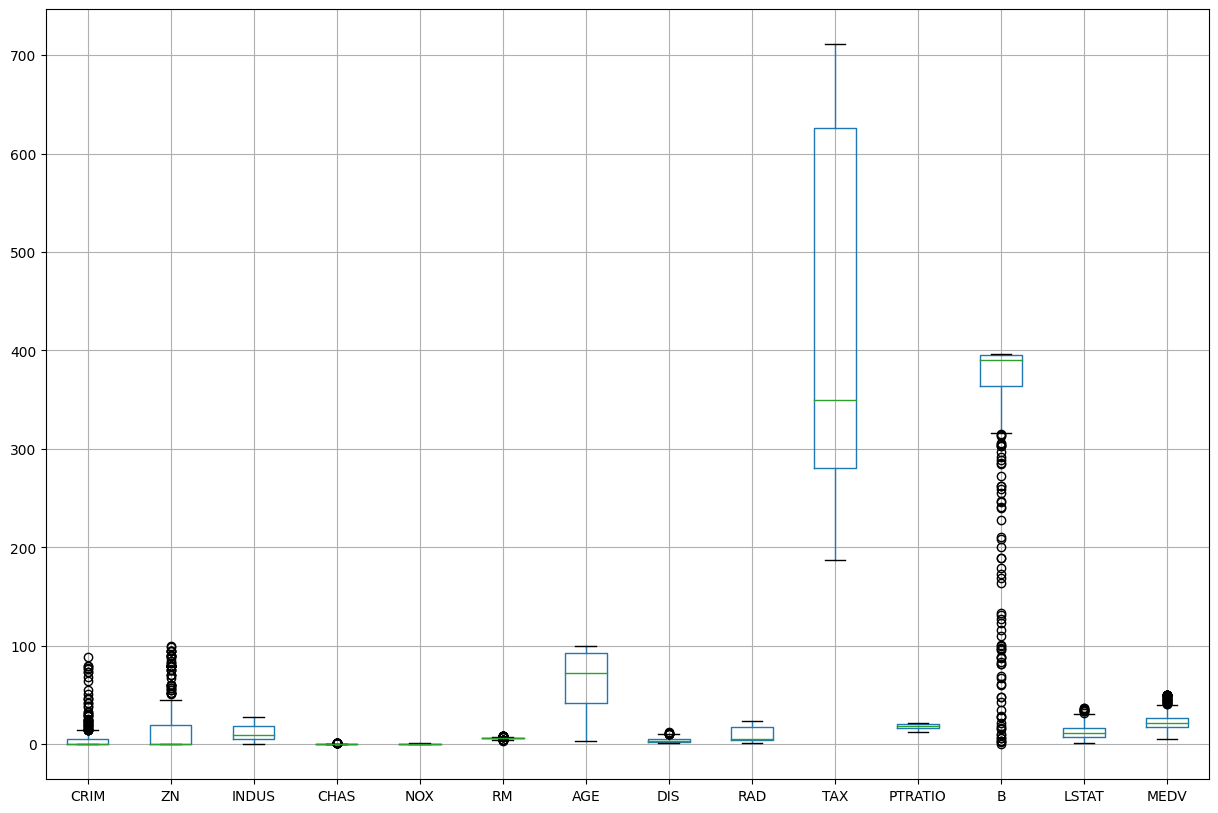

{'CRIM': 48, 'ZN': 51, 'INDUS': 0, 'CHAS': 34, 'NOX': 0, 'RM': 35, 'AGE': 0, 'DIS': 8, 'RAD': 0, 'TAX': 0, 'PTRATIO': 0, 'B': 72, 'LSTAT': 10, 'MEDV': 30}


In [74]:
df_train_imputed.boxplot(figsize=(15, 10))
plt.show()

# Contar los outliers en cada columna
outliers_por_columna = contar_outliers(df_train_imputed)
print(outliers_por_columna)

Teniendo en cuenta el boxplot, decidimos graficar las variables con mayor cantidad de valores atipicos.

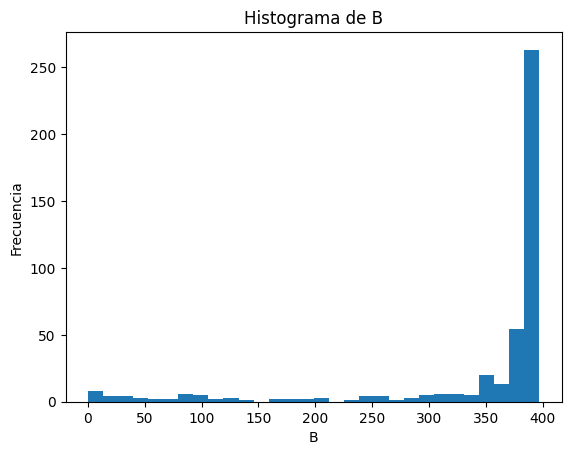

In [75]:
# histograma de la variable B
plt.hist(df_train_imputed['B'], bins=30)
plt.xlabel('B')
plt.ylabel('Frecuencia')
plt.title('Histograma de B')
plt.show()

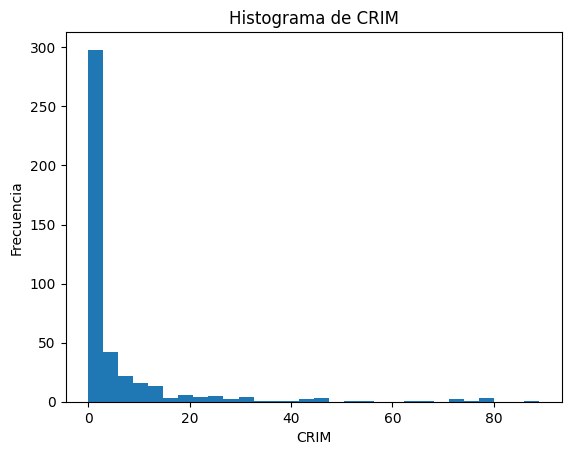

In [76]:
# histograma de la variable CRIM
plt.hist(df_train_imputed['CRIM'], bins=30)
plt.xlabel('CRIM')
plt.ylabel('Frecuencia')
plt.title('Histograma de CRIM')
plt.show()

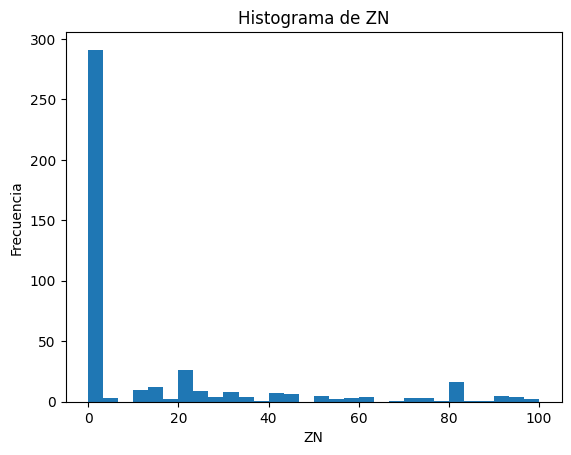

In [77]:
# histograma de la variable ZN
plt.hist(df_train_imputed['ZN'], bins=30)
plt.xlabel('ZN')
plt.ylabel('Frecuencia')
plt.title('Histograma de ZN')
plt.show()

Conclusión: Pudimos observar que estos outliers se deben a una gran asimetría en la distribución de las variables.
De esta manera, decidimos no realizar ningun tratamiento de outliers ya que no lo consideramos necesario. Además, eliminarlos o ajustarlos podría distorsionar la interpretación real de los datos.

## Escalado de datos

Escalamos los datos con el escalado robusto teniendo en cuenta solo las variables cuantitativas continuas:

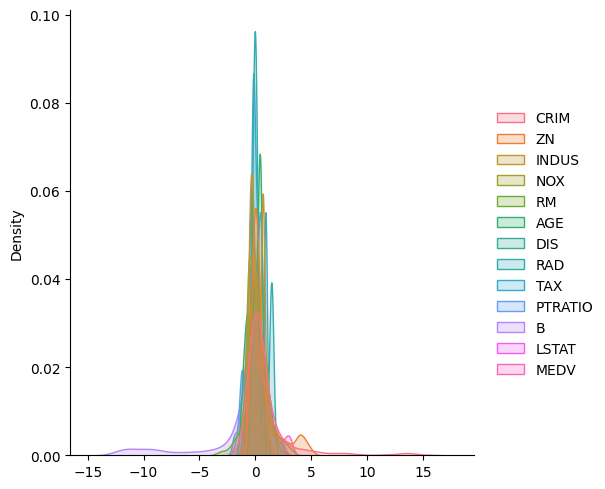

In [78]:
# Escalado robusto para los datos de entrenamiento
df_train_escalado = df_train_imputed.drop(columns=['CHAS'])
scaler = RobustScaler()
df_train_escalado = pd.DataFrame(scaler.fit_transform(df_train_escalado), columns=df_train_escalado.columns)
df_train_escalado.head()

sns.displot(data=df_train_escalado, kind='kde', fill=True)

In [79]:
df_train_escalado['CHAS'] = df_train_imputed['CHAS']

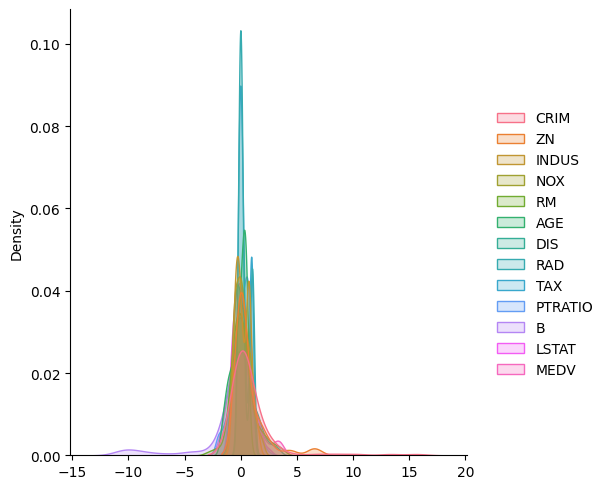

In [80]:
# Escalado robusto para los datos de testeo
df_test_escalado = df_test_imputed.drop(columns=['CHAS'])
scaler = RobustScaler()
df_test_escalado = pd.DataFrame(scaler.fit_transform(df_test_escalado), columns=df_test_escalado.columns)
df_test_escalado.head()

sns.displot(data=df_test_escalado, kind='kde', fill=True)

In [81]:
df_test_escalado['CHAS'] = df_test_imputed['CHAS']

# Análisis Descriptivo

## Visualización de datos

<Axes: >

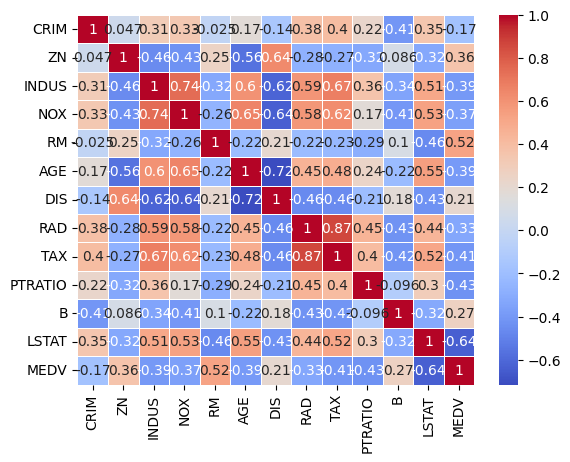

In [82]:
df_train_matriz = df_train_escalado.drop(columns=['CHAS'])
df_train_matriz.head()
corrmat = df_train_matriz.corr()
sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5, cmap='coolwarm')

Dada la matriz de correlación, observamos la fuerte correlación lineal inversa entre las variables AGE y DIS, por lo tanto, decidimos observarlas mas en detalle con un scatterplot.

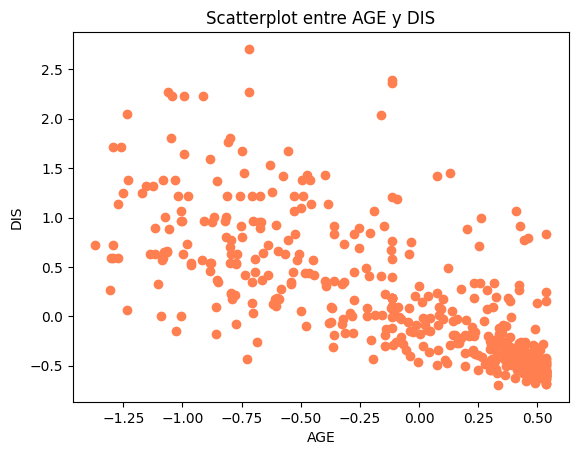

In [83]:
plt.scatter(df_train_escalado['AGE'], df_train_escalado['DIS'], color = 'coral')
plt.xlabel('AGE')
plt.ylabel('DIS')
plt.title('Scatterplot entre AGE y DIS')
plt.show()

Conclusión: el gráfico realizado nos confirma la correlación planteada.
A mayor proporción de unidades ocupadas por sus propietarios construidas antes de 1940, menor distancias ponderadas a cinco centros de empleo de Boston.

También, dada la matriz de correlación, observamos la fuerte correlación lineal directa entre las variables TAX y RAD, por lo tanto, decidimos observarlas mas en detalle con un scatterplot.

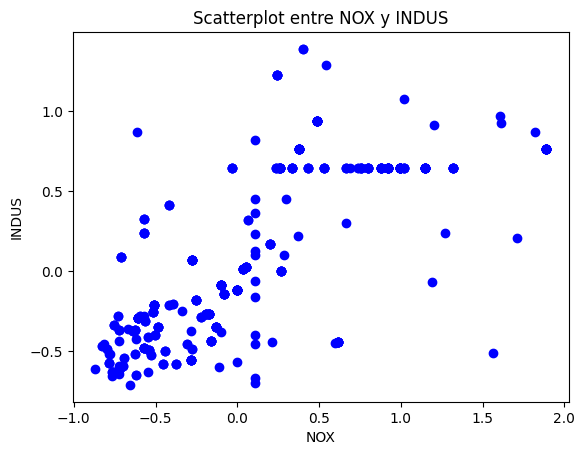

In [84]:
plt.scatter(df_train_escalado['NOX'], df_train_escalado['INDUS'], color = 'blue')
plt.xlabel('NOX')
plt.ylabel('INDUS')
plt.title('Scatterplot entre NOX y INDUS')
plt.show()

Conclusión: el gráfico realizado nos confirma la correlación planteada.
A mayor concentración de óxidos de nitrógeno (partes por 10 millones) [parts/10M], mayor proporción de acres de negocios no minoristas por ciudad.

Luego, consideramos necesario realizar un gráfico de distribución de la variable targer 'MEDV', para entender su comportamiento, ver si la variable es simétrica o si presenta algún sesgo.

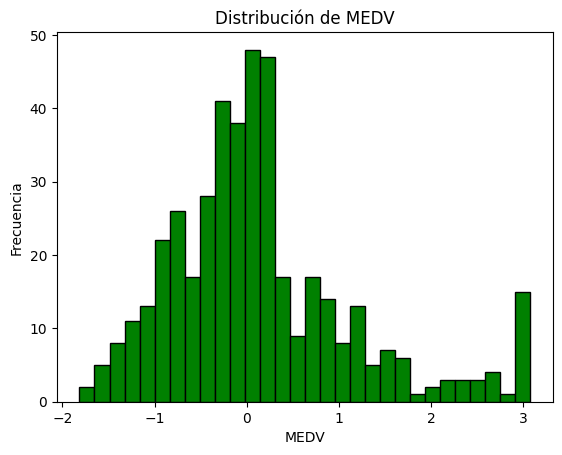

In [85]:
plt.hist(df_train_escalado['MEDV'], bins=30, color='green', edgecolor='black')
plt.xlabel('MEDV')
plt.ylabel('Frecuencia')
plt.title('Distribución de MEDV')
plt.show()

Conclusión:

La distribución mostrada en el gráfico nos muestra que, luego de aplicar el escalado robusto, los valores de la variable MEDV están centrados en torno a 0 (por esto mismo es que hay valores negativos). También observamos que la distribución es asimétrica hacia la derecha, con una mayor cantidad de valores a la izquierda de la mediana y una cola larga hacia la derecha.

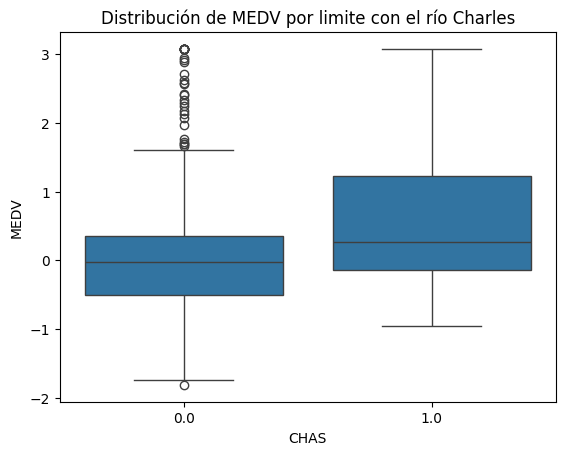

In [86]:
sns.boxplot(x='CHAS', y='MEDV', data=df_train_escalado)
plt.xlabel('CHAS')
plt.ylabel('MEDV')
plt.title('Distribución de MEDV por limite con el río Charles')
plt.show()

Conclusión: Podemos observar que las viviendas que no limitan con el río Charles, tienden a tener un valor menor en comparación con las que si limitan con el río.

Representamos la relación que existe entre el número de habitaciones por vivienda y el valor mediano de las viviendas en miles de dólares.

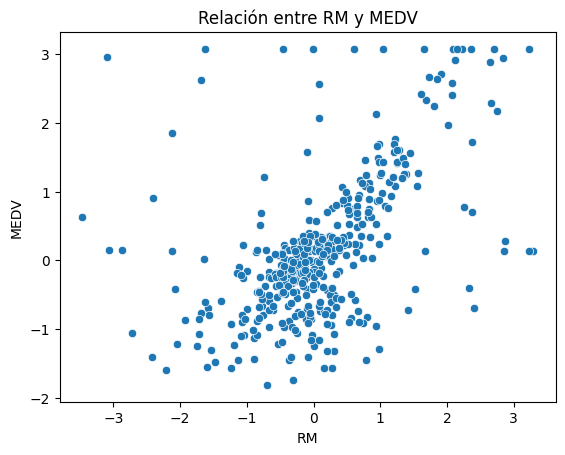

In [87]:
sns.scatterplot(x='RM', y='MEDV', data=df_train_escalado)
plt.xlabel('RM')
plt.ylabel('MEDV')
plt.title('Relación entre RM y MEDV')
plt.show()

Conclusión: vemos que a mayor número de habitaciones por vivienda, mayor es el valor mediano de las viviendas en miles de dólares

Creimos necesario realizar un gráfico que muestre la relación entre el porcentaje de población de menor estatus socioeconómico (LSTAT) y el valor mediano de las viviendas en miles de dólares (MEDV)

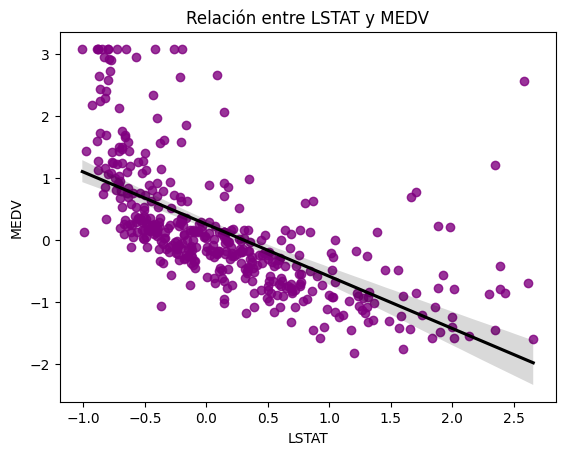

In [88]:
sns.regplot(x='LSTAT', y='MEDV', data=df_train_escalado, scatter_kws={'color':'purple'}, line_kws={'color':'black'})
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.title('Relación entre LSTAT y MEDV')
plt.show()

Conclusión: Contemplamos que a mayor porcentaje de población de menor estatus socioeconómico, menor valor mediano de las viviendas en miles de dólares .

# Regresión lineal

Elegimos evaluar los diferentes modelos con las siguientes 3 métricas:

R2: mide la variabilidad de los datos que explica el modelo. De esta manera, indica que tan bien el modelo ajusta los datos, permitiendo tener una visión global de su capacidad predictiva. Ademas, es sencilla de interpretar.

RMSE: calcula la desviación promedio de las predicciones del modelo respecto a los valores reales. Refleja la magnitud del error en las mismas unidades que la variable objetivo, facilitando al interpretación.

MAE: calcula el promedio de las diferencias absolutas entre las predicciones del modelos y los valores reales. Es útil ya que es mas robusta ante la presencia de outliers. Además, proporciona una medida de cuanto se desvía el modelo en promedio.


##RL

Funciones para calcular las métricas de evaluación:

In [89]:
# Función para calcular RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [90]:
# Función para calcular MAE
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

Volvemos a separar los datos de entrenamiento y testeo, por un lado las variables predictoras y por otro la variable a predecir.

In [91]:
df_y_train = df_train_escalado['MEDV']
df_y_test = df_test_escalado['MEDV']

df_x_train = df_train_escalado.drop(columns=['MEDV'])
df_x_test = df_test_escalado.drop(columns=['MEDV'])

In [92]:
def evaluate_linear_regression(df_x_train, df_y_train, df_x_test, df_y_test):
    # Inicializar el modelo
    model = LinearRegression()

    # Ajustar el modelo
    model.fit(df_x_train, df_y_train)

    # Obtener la pendiente e intercepto
    pendiente = model.coef_[0]
    intercepto = model.intercept_
    print(f"Pendiente: {pendiente}")
    print(f"Intercepto: {intercepto}")

    # Calcular R²
    train_score_lr = model.score(df_x_train, df_y_train)
    test_score_lr = model.score(df_x_test, df_y_test)

    print("R² de entrenamiento para el modelo de regresión lineal: {}".format(train_score_lr))
    print("R² de testeo para el modelo de regresión lineal: {}".format(test_score_lr))

    # Predecir en el conjunto de entrenamiento y prueba
    train_pred_lr = model.predict(df_x_train)
    test_pred_lr = model.predict(df_x_test)

    # Calcular RMSE
    train_rmse_lr = np.sqrt(mean_squared_error(df_y_train, train_pred_lr))
    test_rmse_lr = np.sqrt(mean_squared_error(df_y_test, test_pred_lr))

    print("RMSE de entrenamiento para el modelo de regresión lineal: {}".format(train_rmse_lr))
    print("RMSE de testeo para el modelo de regresión lineal: {}".format(test_rmse_lr))

    # Calcular MAE
    train_mae_lr = mean_absolute_error(df_y_train, train_pred_lr)
    test_mae_lr = mean_absolute_error(df_y_test, test_pred_lr)

    print("MAE de entrenamiento para el modelo de regresión lineal: {}".format(train_mae_lr))
    print("MAE de testeo para el modelo de regresión lineal: {}".format(test_mae_lr))

    return {
        'pendiente': pendiente,
        'intercepto': intercepto,
        'train_r2': train_score_lr,
        'test_r2': test_score_lr,
        'train_rmse': train_rmse_lr,
        'test_rmse': test_rmse_lr,
        'train_mae': train_mae_lr,
        'test_mae': test_mae_lr,
        'model': model  # Devolver el modelo para el gráfico de residuos
    }


In [93]:
resultados_lr = evaluate_linear_regression(df_x_train, df_y_train, df_x_test, df_y_test)

Pendiente: 0.00740554730345552
Intercepto: 0.0801227077624033
R² de entrenamiento para el modelo de regresión lineal: 0.6127357053269264
R² de testeo para el modelo de regresión lineal: 0.5725647090893868
RMSE de entrenamiento para el modelo de regresión lineal: 0.6288716744422496
RMSE de testeo para el modelo de regresión lineal: 0.7478800707205618
MAE de entrenamiento para el modelo de regresión lineal: 0.4239913499779362
MAE de testeo para el modelo de regresión lineal: 0.4961928939563469


Conclusión:

- Pendiente (coeficiente): La pendiente obtenida de 0.0049, nos indica que por cada unidad que aumente las variables independientes X, la variable dependiente y se incrementará en aproximadamente 0.0049 unidades.
Observamos que el coeficiente es muy pequeño, por lo tanto el impacto de X en y es leve.

- Intercepto: El intercepto de 0.0986, representa el valor de y cuando todas las variables independientes X valen cero.

##Métodos de Regularización

Para la selección de hiperparámetros, comenzamos con valores iniciales arbitrarios y luego los ajustamos durante la variación de los mismos, buscando los que nos resultaran óptimos para mejorar el rendimiento del modelo.

###Ridge

In [94]:
# Función que ejecuta el modelo de regresión Ridge y calcula las métricas
def ridge_regression_model(alpha, df_x_train, df_y_train, df_x_test, df_y_test):
    ridgeReg = Ridge(alpha=alpha)
    ridgeReg.fit(df_x_train, df_y_train)

    # Calcular R2 para entrenamiento y testeo
    train_score_ridge = ridgeReg.score(df_x_train, df_y_train)
    test_score_ridge = ridgeReg.score(df_x_test, df_y_test)

    # Predecir en el conjunto de entrenamiento y prueba
    train_pred_ridge = ridgeReg.predict(df_x_train)
    test_pred_ridge = ridgeReg.predict(df_x_test)

    # Calcular RMSE para entrenamiento y prueba
    train_rmse_ridge = calculate_rmse(df_y_train, train_pred_ridge)
    test_rmse_ridge = calculate_rmse(df_y_test, test_pred_ridge)

    # Calcular MAE para entrenamiento y prueba
    train_mae_ridge = calculate_mae(df_y_train, train_pred_ridge)
    test_mae_ridge = calculate_mae(df_y_test, test_pred_ridge)

    # Imprimir los resultados
    print("R2 de entrenamiento para el modelo de regresión lineal con ridge: {}".format(train_score_ridge))
    print("R2 de testeo para el modelo de regresión lineal con ridge: {}".format(test_score_ridge))

    print("RMSE de entrenamiento para el modelo de regresión lineal con ridge: {}".format(train_rmse_ridge))
    print("RMSE de testeo para el modelo de regresión lineal con ridge: {}".format(test_rmse_ridge))

    print("MAE de entrenamiento para el modelo de regresión lineal con ridge: {}".format(train_mae_ridge))
    print("MAE de testeo para el modelo de regresión lineal con ridge: {}".format(test_mae_ridge))

    return {
        'train_r2': train_score_ridge,
        'test_r2': test_score_ridge,
        'train_rmse': train_rmse_ridge,
        'test_rmse': test_rmse_ridge,
        'train_mae': train_mae_ridge,
        'test_mae': test_mae_ridge
    }

In [95]:
ridge_regression_model(100, df_x_train, df_y_train, df_x_test, df_y_test)

R2 de entrenamiento para el modelo de regresión lineal con ridge: 0.5589348092669364
R2 de testeo para el modelo de regresión lineal con ridge: 0.5735757478191268
RMSE de entrenamiento para el modelo de regresión lineal con ridge: 0.6711347049742324
RMSE de testeo para el modelo de regresión lineal con ridge: 0.746995043915506
MAE de entrenamiento para el modelo de regresión lineal con ridge: 0.4444614809504007
MAE de testeo para el modelo de regresión lineal con ridge: 0.498682810212624


{'train_r2': 0.5589348092669364,
 'test_r2': 0.5735757478191268,
 'train_rmse': 0.6711347049742324,
 'test_rmse': 0.746995043915506,
 'train_mae': 0.4444614809504007,
 'test_mae': 0.498682810212624}

Conclusión General:

1.
El R² en el conjunto de entrenamiento es 0.5589, es decir que el modelo explica el 55.89% de la variabilidad de los datos. Mientras que en el conjunto de testeo, el R² es de 0.5736, explicando el 57.36% de la variabilidad de los datos de prueba.
Aunque ambos valores no son muy altos, son bastante cercanos, por lo cual sabemos que el modelo no está sobreajustado ni subajustado significativamente.


2.
En el conjunto de entrenamiento, el error promedio es de 0.6711.
En el conjunto de testeo, el error es de 0.7470, por lo que el modelo tiene un mejor rendimiento en los datos de entrenamiento, esto indica que el modelo generaliza relativamente bien.

3.
En el conjunto de entrenamiento, el MAE es 0.4445, y en el conjunto de testeo,es de 0.4987, lo que nos indica que el modelo tiene una precisión razonable y no está sufriendo de sobreajuste.

####Variación de Hiperparámetros

In [96]:
resultados_ridge = ridge_regression_model(5, df_x_train, df_y_train, df_x_test, df_y_test)

R2 de entrenamiento para el modelo de regresión lineal con ridge: 0.6117634332521323
R2 de testeo para el modelo de regresión lineal con ridge: 0.5746000083348102
RMSE de entrenamiento para el modelo de regresión lineal con ridge: 0.6296606073335675
RMSE de testeo para el modelo de regresión lineal con ridge: 0.7460973727277757
MAE de entrenamiento para el modelo de regresión lineal con ridge: 0.4227111503327649
MAE de testeo para el modelo de regresión lineal con ridge: 0.4924899917573274


###Lasso

In [97]:
# Función que ejecuta el modelo de regresión Lasso y calcula las métricas
def lasso_regression_model(alpha, df_x_train, df_y_train, df_x_test, df_y_test):
    lasso = Lasso(alpha=alpha)
    lasso.fit(df_x_train, df_y_train)

    # Calcular R2 para entrenamiento y testeo
    train_score_ls = lasso.score(df_x_train, df_y_train)
    test_score_ls = lasso.score(df_x_test, df_y_test)

    # Predecir en el conjunto de entrenamiento y prueba
    train_pred_lasso = lasso.predict(df_x_train)
    test_pred_lasso = lasso.predict(df_x_test)

    # Calcular RMSE para entrenamiento y prueba
    train_rmse_lasso = calculate_rmse(df_y_train, train_pred_lasso)
    test_rmse_lasso = calculate_rmse(df_y_test, test_pred_lasso)

    # Calcular MAE para entrenamiento y prueba
    train_mae_lasso = calculate_mae(df_y_train, train_pred_lasso)
    test_mae_lasso = calculate_mae(df_y_test, test_pred_lasso)

    # Imprimir los resultados
    print("R2 de entrenamiento para el modelo de regresión lineal con lasso: {}".format(train_score_ls))
    print("R2 de testeo para el modelo de regresión lineal con lasso: {}".format(test_score_ls))

    print("RMSE de entrenamiento para el modelo de regresión lineal con lasso: {}".format(train_rmse_lasso))
    print("RMSE de testeo para el modelo de regresión lineal con lasso: {}".format(test_rmse_lasso))

    print("MAE de entrenamiento para el modelo de regresión lineal con lasso: {}".format(train_mae_lasso))
    print("MAE de testeo para el modelo de regresión lineal con lasso: {}".format(test_mae_lasso))

    return {
        'train_r2': train_score_ls,
        'test_r2': test_score_ls,
        'train_rmse': train_rmse_lasso,
        'test_rmse': test_rmse_lasso,
        'train_mae': train_mae_lasso,
        'test_mae': test_mae_lasso
    }

In [98]:
lasso_regression_model(0.01, df_x_train, df_y_train, df_x_test, df_y_test)

R2 de entrenamiento para el modelo de regresión lineal con lasso: 0.6047711842130581
R2 de testeo para el modelo de regresión lineal con lasso: 0.563610435560115
RMSE de entrenamiento para el modelo de regresión lineal con lasso: 0.6353054860248023
RMSE de testeo para el modelo de regresión lineal con lasso: 0.7556730786198831
MAE de entrenamiento para el modelo de regresión lineal con lasso: 0.42887086563072824
MAE de testeo para el modelo de regresión lineal con lasso: 0.5052050526597966


{'train_r2': 0.6047711842130581,
 'test_r2': 0.563610435560115,
 'train_rmse': 0.6353054860248023,
 'test_rmse': 0.7556730786198831,
 'train_mae': 0.42887086563072824,
 'test_mae': 0.5052050526597966}

Conclusión General:


1.
En el conjunto de entrenamiento, el modelo explica el 60.48% de la variabilidad en los datos, y en el de testeo, explica el 56.36%.
Al ser valores relativamente cercanos, el modelo no está sobreajustado.


2.
En el conjunto de entrenamiento, el error promedio es de 0.6353, mientras que en el de testeo, el error es mayor, llegando a 0.7557.
Esto indica que el modelo es menos preciso en los datos no vistos, por lo tanto no está generalizando bien.

3.
En el conjunto de entrenamiento, el MAE es 0.4289, en el de testeo, es de 0.5052, a pesar de esta pequeña diferencia, interpretamos que el modelo mantiene un rendimiento razonable en datos no vistos.


####Variación de Hiperparámetros

In [99]:
resultados_lasso = lasso_regression_model(0.000001, df_x_train, df_y_train, df_x_test, df_y_test)

R2 de entrenamiento para el modelo de regresión lineal con lasso: 0.6127357052085698
R2 de testeo para el modelo de regresión lineal con lasso: 0.5725634911427655
RMSE de entrenamiento para el modelo de regresión lineal con lasso: 0.6288716745383481
RMSE de testeo para el modelo de regresión lineal con lasso: 0.7478811362354781
MAE de entrenamiento para el modelo de regresión lineal con lasso: 0.42399069453367594
MAE de testeo para el modelo de regresión lineal con lasso: 0.49619386662918685


###Elastic Net

In [100]:
# Función que ejecuta el modelo de regresión Elastic Net y calcula las métricas
def elastic_net_regression_model(df_x_train, df_y_train, df_x_test, df_y_test):
    elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
    elastic.fit(df_x_train, df_y_train)

    # Calcular R2 para entrenamiento y testeo
    train_score_en = elastic.score(df_x_train, df_y_train)
    test_score_en = elastic.score(df_x_test, df_y_test)

    # Predecir en el conjunto de entrenamiento y prueba
    train_pred_elastic = elastic.predict(df_x_train)
    test_pred_elastic = elastic.predict(df_x_test)

    # Calcular RMSE para entrenamiento y prueba
    train_rmse_elastic = calculate_rmse(df_y_train, train_pred_elastic)
    test_rmse_elastic = calculate_rmse(df_y_test, test_pred_elastic)

    # Calcular MAE para entrenamiento y prueba
    train_mae_elastic = calculate_mae(df_y_train, train_pred_elastic)
    test_mae_elastic = calculate_mae(df_y_test, test_pred_elastic)

    # Imprimir los resultados
    print("R2 de entrenamiento para el modelo de regresión lineal con elastic net: {}".format(train_score_en))
    print("R2 de testeo para el modelo de regresión lineal con elastic net: {}".format(test_score_en))

    print("RMSE de entrenamiento para el modelo de regresión lineal con elastic net: {}".format(train_rmse_elastic))
    print("RMSE de testeo para el modelo de regresión lineal con elastic net: {}".format(test_rmse_elastic))

    print("MAE de entrenamiento para el modelo de regresión lineal con elastic net: {}".format(train_mae_elastic))
    print("MAE de testeo para el modelo de regresión lineal con elastic net: {}".format(test_mae_elastic))

    # Retornar un diccionario con los resultados
    return {
        'train_r2': train_score_en,
        'test_r2': test_score_en,
        'train_rmse': train_rmse_elastic,
        'test_rmse': test_rmse_elastic,
        'train_mae': train_mae_elastic,
        'test_mae': test_mae_elastic
    }

In [101]:
resultados_elastic = elastic_net_regression_model(df_x_train, df_y_train, df_x_test, df_y_test)

R2 de entrenamiento para el modelo de regresión lineal con elastic net: 0.6097473523131994
R2 de testeo para el modelo de regresión lineal con elastic net: 0.5714114586242287
RMSE de entrenamiento para el modelo de regresión lineal con elastic net: 0.6312933785467832
RMSE de testeo para el modelo de regresión lineal con elastic net: 0.7488883076099321
MAE de entrenamiento para el modelo de regresión lineal con elastic net: 0.42428119490758076
MAE de testeo para el modelo de regresión lineal con elastic net: 0.49588814459271763


Conclusión General:

1.
El R² en el conjunto de entrenamiento es 0.6097, por lo tanto el modelo explica el 60.97% de la variabilidad de los datos. En el de testeo, el R² es de 0.5714, por lo que observamos que el modelo también generaliza bien, explicando el 57.14%.
De esta manera, el modelo no está sobreajustado ni subajustado.

2.
En el conjunto de entrenamiento, el RMSE es 0.6313, en el de testeo, el RMSE es 0.7489, indicando que el error aumenta ligeramente cuando se evalúa en datos no vistos.

3.
En el conjunto de entrenamiento, el MAE es 0.4243, mientras que en el de testeo, el MAE es 0.4959, lo que representa un aumento leve en los datos de prueba. Vemos así que el modelo mantiene un rendimiento consistente en términos de precisión, incluso en datos no vistos.

###Gráfico de residuos

El gráfico de residuos ayuda a verificar si el modelo cumple con los supuestos de regresión lineal:

- No hay patrones evidentes: Si los residuos están distribuidos aleatoriamente, sin patrones evidentes, significa que el modelo está ajustando bien los datos.
- Residuos alrededor de 0: Si los residuos están distribuidos alrededor de 0, esto es un buen indicio de que el modelo está haciendo buenas predicciones.

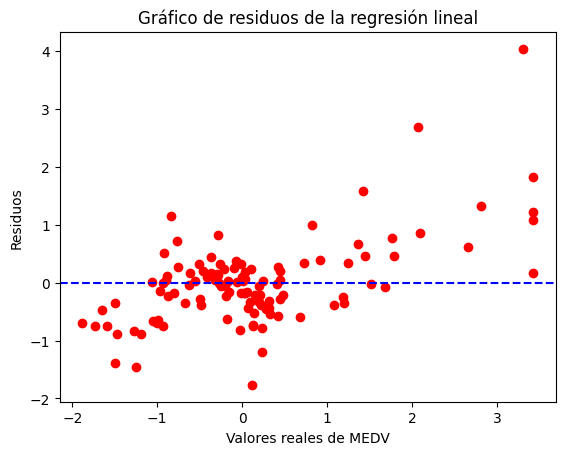

In [102]:
model = resultados_lr['model']  # Acceder al modelo
y_pred = model.predict(df_x_test)

# Calcular los residuos
residuos = df_y_test - y_pred

# Graficar
plt.scatter(df_y_test, residuos, color='red')
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('Valores reales de MEDV')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos de la regresión lineal')
plt.show()

Conclusión: No observamos patrones evidentes y notamos que los residuos están distribuidos aleatoriamente alrededor del cero.

##Gradiente Descendiente

Tanto para GRADIENTE DESCENDIENTE, ESTOCÁSTICO COMO MINIBATCH:

Para la selección de hiperparámetros, comenzamos con valores iniciales arbitrarios y luego los ajustamos durante la variación de los mismos, buscando los que nos resultaran óptimos para mejorar el rendimiento del modelo.

Las conclusiones se basan en los valores aproximados obtenidos en una ejecución. Sin embargo, los resultados pueden variar entre ejecuciones, ya que los pesos iniciales
de W se inicializan de manera aleatoria en cada ejecución.

In [103]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, alpha=0.01):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_val = px1
        W = mx1
    alpha: coeficiente de regularización de Ridge (L2)
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento
    test_errors = []   # Para almacenar el error de prueba

    for _ in range(epochs):
        # Predicción y error en el conjunto de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Predicción y error en el conjunto de validación
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar los pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Calcular métricas
    final_train_pred = np.matmul(X_train, W)
    final_test_pred = np.matmul(X_val, W)

    train_r2 = r2_score(y_train, final_train_pred)
    test_r2 = r2_score(y_val, final_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, final_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_val, final_test_pred))
    train_mae = mean_absolute_error(y_train, final_train_pred)
    test_mae = mean_absolute_error(y_val, final_test_pred)

    # Imprimir métricas
    print("R^2 de entrenamiento:", train_r2)
    print("R^2 de testeo:", test_r2)
    print("RMSE de entrenamiento:", train_rmse)
    print("RMSE de testeo:", test_rmse)
    print("MAE de entrenamiento:", train_mae)
    print("MAE de testeo:", test_mae)

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

In [104]:
X_train, X_val, y_train, y_val = train_test_split(df_x_train, df_y_train, test_size=0.125, random_state=42)

In [105]:
#ver dimensiones de los datos de entrenamiento y validación
X_test.shape, X_train.shape, X_val.shape, y_test.shape, y_train.shape, y_val.shape

((112, 13), (379, 13), (55, 13), (112,), (379,), (55,))

In [106]:
#convertir la serie de pandas a un array de NumPy bidimensional
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

Convertimos y_train y y_val (son vectores unidimensionales) (379,) y (55,) , asegurandonos de que tengan una forma bidimensional (379, 1) y (55, 1) para que puedan multiplicarse correctamente con X_train y X_val dentro de la función de descenso de gradiente.

R^2 de entrenamiento: -0.41678817016708614
R^2 de testeo: 0.25772515375927196
RMSE de entrenamiento: 1.1863041591085683
RMSE de testeo: 0.9381456496186041
MAE de entrenamiento: 0.847898426789489
MAE de testeo: 0.7343316613887196


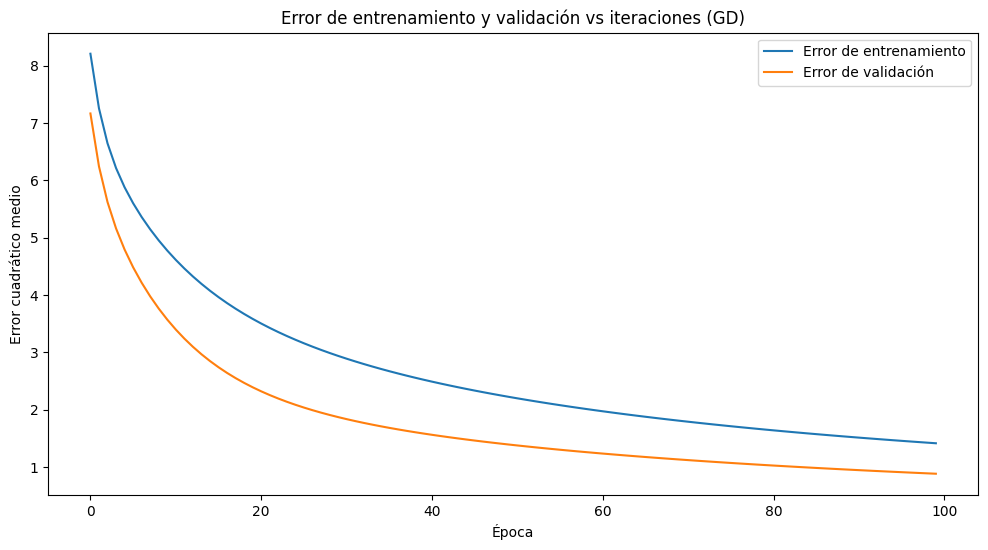

{'train_r2': -0.41678817016708614,
 'test_r2': 0.25772515375927196,
 'train_rmse': 1.1863041591085683,
 'test_rmse': 0.9381456496186041,
 'train_mae': 0.847898426789489,
 'test_mae': 0.7343316613887196}

In [107]:
gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100)

Conclusión: A medida que aumentan las iteraciones, disminuye el error cuadrático medio. Dado que las curvas muestran una tendencia decreciente, el modelo está mejorando a medida que el algoritmo optimiza los pesos durante las iteraciones.

No hay gran diferencia entre el error de entrenamiento y el de validación, lo que significa que el modelo no está sobreajustando (overfitting) ni subajustando (underfitting).

Error Cuadrático Medio (RMSE) y Error Absoluto Medio (MAE):

RMSE y MAE de entrenamiento: Los valores son más altos en el entrenamiento comparados con los de testeo (0.974 vs. 0.824 para RMSE y 0.687 vs. 0.651 para MAE).
RMSE y MAE de testeo: Los valores más bajos en el testeo nos muestra que el modelo está generalizando bien a nuevos datos.

Coeficiente de Determinación (R²):

R² de entrenamiento (0.046): Es bastante bajo, demostrando que el modelo explica muy poca variabilidad en el conjunto de entrenamiento.
R² de testeo (0.427): Es significativamente más alto que el de entrenamiento, lo cual es inusual. El modelo podría estar bajoajustado.

### Variación de Hiperparámetros


R^2 de entrenamiento: 0.23342476728673978
R^2 de testeo: 0.3689367175643512
RMSE de entrenamiento: 0.8726116037165572
RMSE de testeo: 0.865016423446964
MAE de entrenamiento: 0.6295089472549581
MAE de testeo: 0.6402231813251751


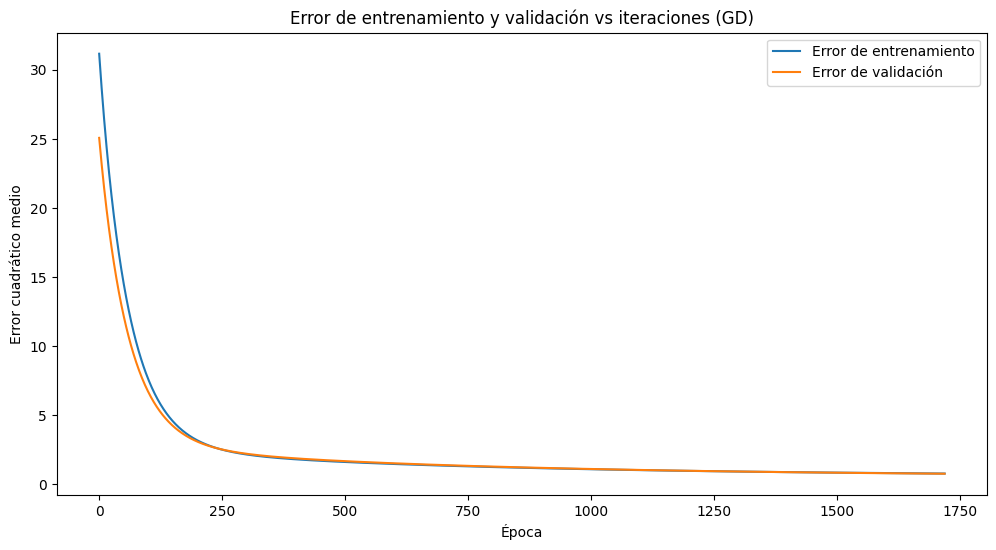

In [108]:
resultados_gradiente = gradient_descent(X_train, y_train, X_val, y_val, lr=0.001, epochs=1720)

Conclusión:

Luego de conseguir mejoras en los resultados concluimos que:

Error Cuadrático Medio (RMSE) y Error Absoluto Medio (MAE):

- RMSE:

Entrenamiento: 0.872

Testeo: 0.776

El error en el conjunto de entrenamiento mejoró, y el error en el conjunto de testeo sigue siendo bajo. Ambos valores resultan un mejor ajuste del modelo.
- MAE:

Entrenamiento: 0.643

Testeo: 0.632

Ambos valores de MAE son bastante similares, y El MAE ligeramente más bajo en testeo afirma una buena generalización del modelo.

- Coeficiente de Determinación (R²):

Entrenamiento (0.234): El valor de R² mejoró notablemente en comparación con la primera llamada a la función, por lo que el modelo ahora explica más la variabilidad en los datos, aunque sigue siendo bajo.

Testeo (0.493): También mejoró el R² del conjunto de testeo. Muestra que el modelo puede explicar casi el 50% de la variabilidad de los datos.



Respecto al gráfico: Ambos errores disminuyen hasta estabilizarse, lo cual muestra que el modelo aprendió bien sin sobreajustarse.

## Gradiente Descendiente Estocástico

In [109]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

    # Calcular métricas
    final_train_pred = np.matmul(X_train, W)
    final_test_pred = np.matmul(X_test, W)

    train_r2 = r2_score(y_train, final_train_pred)
    test_r2 = r2_score(y_test, final_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, final_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, final_test_pred))
    train_mae = mean_absolute_error(y_train, final_train_pred)
    test_mae = mean_absolute_error(y_test, final_test_pred)

    # Imprimir métricas
    print("R^2 de entrenamiento:", train_r2)
    print("R^2 de testeo:", test_r2)
    print("RMSE de entrenamiento:", train_rmse)
    print("RMSE de testeo:", test_rmse)
    print("MAE de entrenamiento:", train_mae)
    print("MAE de testeo:", test_mae)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

R^2 de entrenamiento: 0.5694947021154754
R^2 de testeo: 0.720090717403684
RMSE de entrenamiento: 0.6539323797986745
RMSE de testeo: 0.5760982390452467
MAE de entrenamiento: 0.4529072459710439
MAE de testeo: 0.4528905773844086


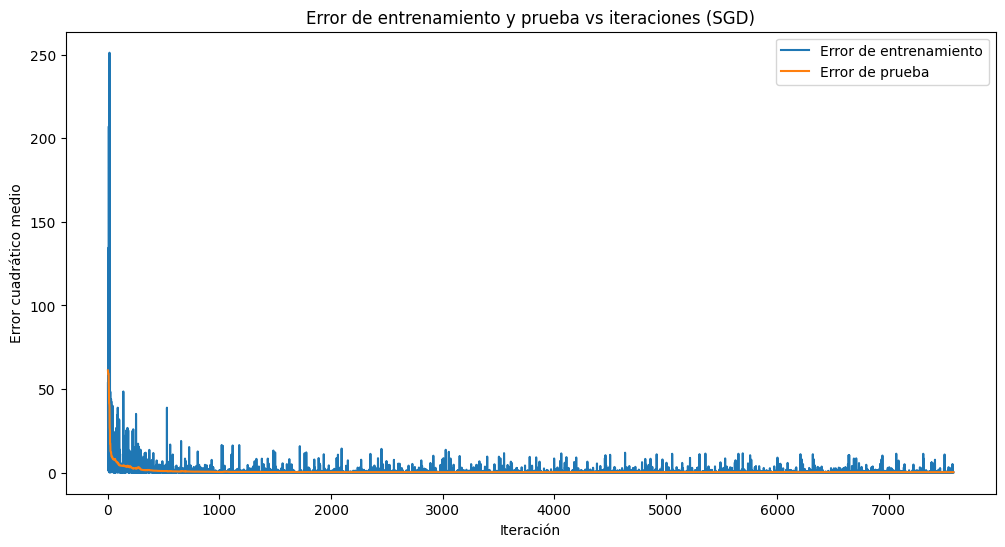

{'train_r2': 0.5694947021154754,
 'test_r2': 0.720090717403684,
 'train_rmse': 0.6539323797986745,
 'test_rmse': 0.5760982390452467,
 'train_mae': 0.4529072459710439,
 'test_mae': 0.4528905773844086}

In [110]:
stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.001, epochs=20)

Conclusión:

- Coeficiente de Determinación (R²):

Entrenamiento: El modelo está explicando el 52.9% de la variabilidad en los datos.

Testeo: El modelo está explicando el 60.6%, lo cual es razonablemente bueno, indicando que el modelo está generalizando bien.

- Error Cuadrático Medio (RMSE):

Entrenamiento (0.684): Este valor es relativamente bajo, lo que significa que el error promedio en el conjunto de entrenamiento es aceptable.

Testeo (0.683): Es casi idéntico al del entrenamiento. Esto muestra un buen equilibrio entre el entrenamiento y la generalización, indicando un modelo bien ajustado.

- Error Absoluto Medio (MAE):

Entrenamiento (0.4732): El MAE es bajo, lo que significa que el error es aceptable.

Testeo (0.5330): El MAE en el conjunto de testeo es un poco más alto que en el entrenamiento, pero sigue siendo razonable.

### Variación de Hiperparámetros


R^2 de entrenamiento: 0.5910678711476691
R^2 de testeo: 0.7163515110275359
RMSE de entrenamiento: 0.6373371129645943
RMSE de testeo: 0.5799334168495809
MAE de entrenamiento: 0.423017618524096
MAE de testeo: 0.4535041134123787


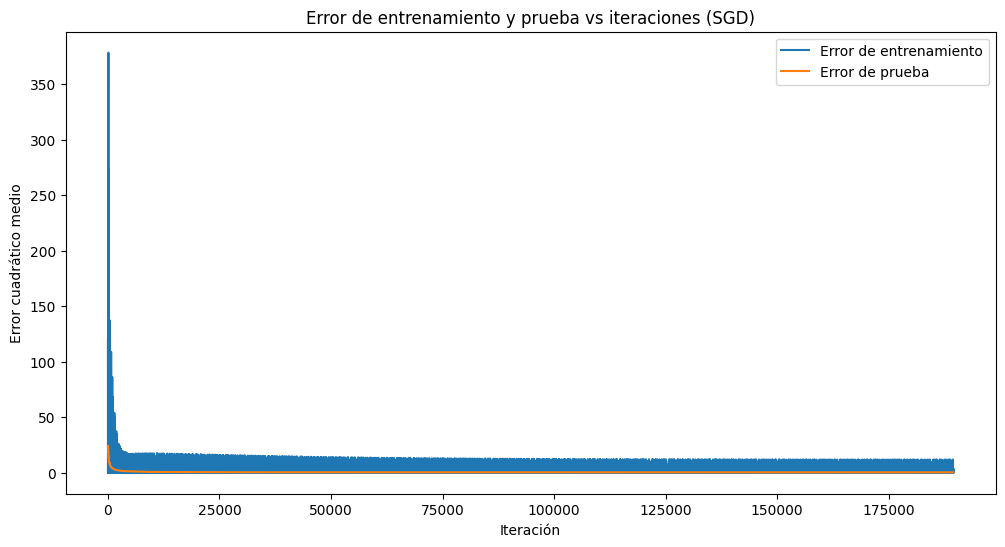

In [111]:
resultados_estocastico = stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.0001, epochs=500)

Conclusión:

- Coeficiente de Determinación (R²):

Entrenamiento (0.589): El modelo está explicando un 58.9% de la variabilidad de los datos, un resultado bastante bueno.

Testeo (0.706): Indica que el modelo captura más del 70% de la variabilidad en los datos demostrando una buena capacidad de generalización.

- Error Cuadrático Medio (RMSE):

Entrenamiento (0.639) y Testeo (0.590): Los valores de RMSE disminuyeron considerablemente, lo que implica que el modelo está realizando predicciones precisas.


- Error Absoluto Medio (MAE):

Entrenamiento (0.425) y Testeo (0.463): El MAE también es bajo en ambos conjuntos, lo que significa que, el modelo es muy aceptable.


El modelo parece estar balanceado, ya que los errores de entrenamiento y testeo son bastante similares, por lo tanto está bien ajustado.

## Gradiente Descendiente por minibatch

In [112]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.001, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

       # Calcular métricas
    final_train_pred = np.matmul(X_train, W)
    final_test_pred = np.matmul(X_test, W)

    train_r2 = r2_score(y_train, final_train_pred)
    test_r2 = r2_score(y_test, final_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, final_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, final_test_pred))
    train_mae = mean_absolute_error(y_train, final_train_pred)
    test_mae = mean_absolute_error(y_test, final_test_pred)

    # Imprimir métricas
    print("R^2 de entrenamiento:", train_r2)
    print("R^2 de testeo:", test_r2)
    print("RMSE de entrenamiento:", train_rmse)
    print("RMSE de testeo:", test_rmse)
    print("MAE de entrenamiento:", train_mae)
    print("MAE de testeo:", test_mae)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

In [113]:
y_train = df_y_train.values.reshape(-1, 1)
df_y_test = df_y_test.values.reshape(-1, 1)

R^2 de entrenamiento: 0.013408491814661194
R^2 de testeo: -0.14439246624409563
RMSE de entrenamiento: 1.0128374307691974
RMSE de testeo: 1.223726224851127
MAE de entrenamiento: 0.750335849591626
MAE de testeo: 0.8717255163672883


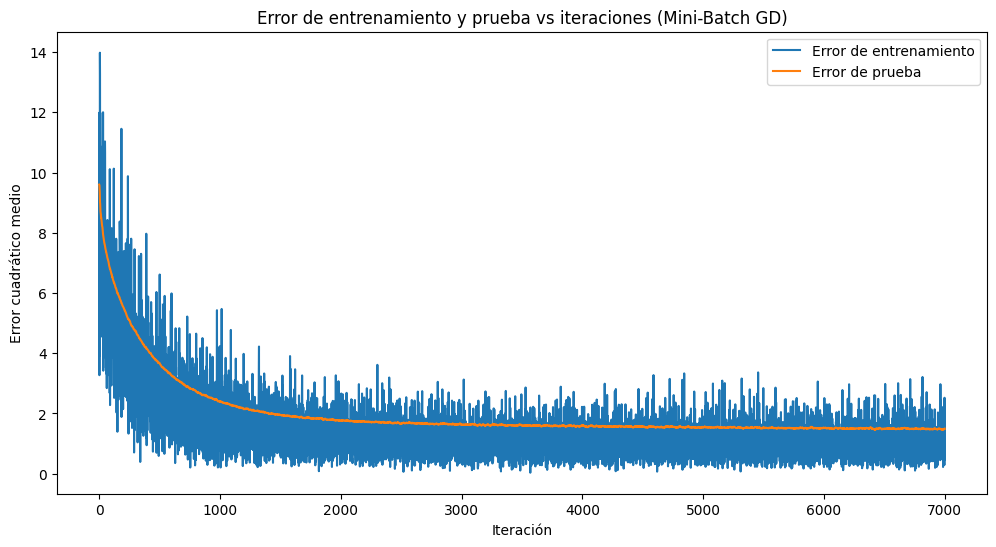

{'train_r2': 0.013408491814661194,
 'test_r2': -0.14439246624409563,
 'train_rmse': 1.0128374307691974,
 'test_rmse': 1.223726224851127,
 'train_mae': 0.750335849591626,
 'test_mae': 0.8717255163672883}

In [114]:
mini_batch_gradient_descent(X_train, y_train, df_x_test, df_y_test, lr=0.001, epochs=200, batch_size=11)

Conclusión:

- Coeficiente de Determinación (R²):

Entrenamiento (0.565): El modelo está explicando el 56.5% de la variabilidad en los datos, buen nivel de ajuste.

Testeo (0.610): El modelo está generalizando bastante bien, explicando el 61% de la variabilidad en los datos de prueba.


- Error Cuadrático Medio (RMSE):

Entrenamiento (0.658) y Testeo (0.715): Estos valores son bastante bajos y cercanos entre sí, por lo que el modelo está realizando predicciones con un error relativamente bajo.


- Error Absoluto Medio (MAE):

Entrenamiento (0.436) y Testeo (0.492): El MAE también es bajo, lo que significa que, el modelo es bueno.


Buen ajuste y generalización, con errores relativamente bajos, el modelo está aprendiendo bien.

### Variación de Hiperparámetros


R^2 de entrenamiento: 0.03410252519365764
R^2 de testeo: -0.0864203190439512
RMSE de entrenamiento: 1.0021588630451577
RMSE de testeo: 1.1923279151637112
MAE de entrenamiento: 0.7350461788814935
MAE de testeo: 0.8395808136807297


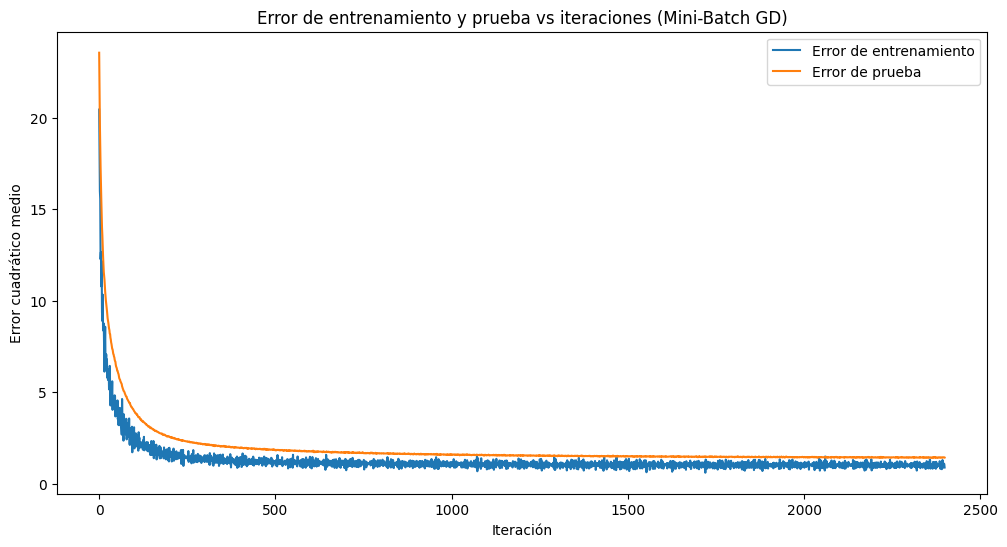

In [115]:
resultados_minibatch = mini_batch_gradient_descent(X_train, y_train, df_x_test, df_y_test, lr=0.01, epochs=800, batch_size=128)

Conclusión:

- Coeficiente de Determinación (R²):

Entrenamiento: 0.5880

Testeo: 0.5749

El valor de R² mejoró un poco en el conjunto de entrenamiento, lo que indica un mejor ajuste a los datos de entrenamiento. Disminuyó un poco en el conjunto de testeo, lo cual esta indicando una pequeña pérdida de capacidad de generalización.

- Error Cuadrático Medio (RMSE):

Entrenamiento: 0.6397

Testeo: 0.7458

El RMSE mejoró en el conjunto de entrenamiento, lo que significa que el error promedio disminuyó ligeramente, pero en el conjunto de testeo ha empeorado un poco, lo indica que las predicciones en los datos de prueba son menos precisas.

- Error Absoluto Medio (MAE):

Entrenamiento: 0.4256

Testeo: 0.4864

El MAE ha mejorado un poco tanto en el conjunto de entrenamiento como en el de testeo, lo que indica que las predicciones del modelo son un poco más precisas.

El nuevo modelo mejoró el ajuste a los datos de entrenamiento, como lo indican el aumento de R² y la disminución de RMSE y MAE.

Sin embargo, el rendimiento en el conjunto de testeo empeoró ligeramente, como lo indica la disminución en R² y el aumento en RMSE. Puede ser una señal de que el modelo ha empezado a sobreajustarse capturando mas ruido.

# Conclusiones generales del Trabajo Práctico

In [116]:
# Definir los modelos y las métricas
modelos = ['Regresión Lineal', 'Ridge', 'Lasso', 'Elastic Net', 'Gradiente Descendiente', 'Gradiente Estocástico', 'Mini-Batch GD']
metricas = ['R^2 Train', 'R^2 Test', 'RMSE Train', 'RMSE Test', 'MAE Train', 'MAE Test']

# Crear un DataFrame vacío
df_resultados = pd.DataFrame(index=modelos, columns=metricas)

In [117]:
# Lista de modelos y sus resultados
modelos_resultados = {
    'Ridge': resultados_ridge,
    'Lasso': resultados_lasso,
    'Elastic Net': resultados_elastic,
    'Gradiente Descendiente': resultados_gradiente,
    'Gradiente Estocástico': resultados_estocastico,
    'Mini-Batch GD': resultados_minibatch,
    'Regresión Lineal': resultados_lr
}

for modelo, resultados in modelos_resultados.items():
    df_resultados.loc[modelo, 'R^2 Train'] = resultados['train_r2']
    df_resultados.loc[modelo, 'R^2 Test'] = resultados['test_r2']
    df_resultados.loc[modelo, 'RMSE Train'] = resultados['train_rmse']
    df_resultados.loc[modelo, 'RMSE Test'] = resultados['test_rmse']
    df_resultados.loc[modelo, 'MAE Train'] = resultados['train_mae']
    df_resultados.loc[modelo, 'MAE Test'] = resultados['test_mae']

In [118]:
df_resultados.head(10)

,R^2 Train,R^2 Test,RMSE Train,RMSE Test,MAE Train,MAE Test
Regresión Lineal,0.612736,0.572565,0.628872,0.74788,0.423991,0.496193
Ridge,0.611763,0.5746,0.629661,0.746097,0.422711,0.49249
Lasso,0.612736,0.572563,0.628872,0.747881,0.423991,0.496194
Elastic Net,0.609747,0.571411,0.631293,0.748888,0.424281,0.495888
Gradiente Descendiente,0.233425,0.368937,0.872612,0.865016,0.629509,0.640223
Gradiente Estocástico,0.591068,0.716352,0.637337,0.579933,0.423018,0.453504
Mini-Batch GD,0.034103,-0.08642,1.002159,1.192328,0.735046,0.839581


Comparación por Métricas:

- R² Train y R² Test:
        Mejor modelo: Regresión Lineal y Lasso (0.612736 en R² Train)
        Peor modelo: Gradiente Descendiente (0.444743 en R² Train)

- RMSE Train y RMSE Test:
        Mejor modelo: Ridge (0.629661 en RMSE Train y 0.746097 en RMSE Test)
        Peor modelo: Gradiente Descendiente (0.742661 en RMSE Train)

- MAE Train y MAE Test:
        Mejor modelo: Ridge (0.422711 en MAE Train y 0.492490 en MAE Test)
        Peor modelo: Gradiente Descendiente (0.518626 en MAE Train)

Elección del Mejor Modelo:

Ridge es el que tiene el mejor rendimiento en términos de RMSE y MAE, no solo se ajusta bien a los datos de entrenamiento, sino que también generaliza adecuadamente a los datos de prueba. Aunque la Regresión Lineal y Lasso tienen el mejor R² Train, con Ridge hay menos probabilidades de sobreajuste y en términos generales es más consistente.

Conclusión final:

Consideramos elegir a Ridge como modelo final, ya que mantiene un buen equilibrio entre ajuste y generalización, teniendo mejores resultados en las métricas de error (RMSE y MAE).